In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


In [2]:
import h5py
import numpy as np

# Load the HDF5 files
photon_file = h5py.File("/kaggle/input/data-data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "r")
electron_file = h5py.File("/kaggle/input/data-data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", "r")

# Check what datasets are inside the files
print(list(photon_file.keys()))  # Should show available datasets
print(list(electron_file.keys()))  


['X', 'y']
['X', 'y']


In [3]:
X_photon = np.array(photon_file["X"])
y_photon = np.zeros(X_photon.shape[0], dtype=np.int64)

X_electron = np.array(electron_file["X"])
y_electron = np.ones(X_electron.shape[0], dtype=np.int64)

X = np.concatenate([X_photon, X_electron], axis=0)
y = np.concatenate([y_photon, y_electron], axis=0)


In [4]:
# Extract the matrices (features) and labels
X_photons = np.array(photon_file["X"])  # Shape: (N_photons, 32, 32, 2)
y_photons = np.array(photon_file["y"])  # Labels: Should be all 0s

X_electrons = np.array(electron_file["X"])  # Shape: (N_electrons, 32, 32, 2)
y_electrons = np.array(electron_file["y"])  # Labels: Should be all 1s

print("Photon Data Shape:", X_photons.shape)
print("Electron Data Shape:", X_electrons.shape)
print("Photon Labels:", y_photons.shape)
print("Electron Labels:", y_electrons.shape)


Photon Data Shape: (249000, 32, 32, 2)
Electron Data Shape: (249000, 32, 32, 2)
Photon Labels: (249000,)
Electron Labels: (249000,)


In [5]:
from sklearn.utils import shuffle

# Merge datasets
X = np.concatenate([X_photons, X_electrons], axis=0)
y = np.concatenate([y_photons, y_electrons], axis=0)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)

print("Final Dataset Shape:", X.shape)  
print("Final Labels Shape:", y.shape)  


Final Dataset Shape: (498000, 32, 32, 2)
Final Labels Shape: (498000,)


In [6]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split
train_size = int(0.8 * len(X_tensor))
test_size = len(X_tensor) - train_size
train_data, test_data = random_split(TensorDataset(X_tensor, y_tensor), [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


In [8]:
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Data Normalization ---
mean = X_tensor.mean(dim=(0, 2, 3), keepdim=True)
std = X_tensor.std(dim=(0, 2, 3), keepdim=True)
X_tensor = (X_tensor - mean) / (std + 1e-7)

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

In [10]:
class ResNet15(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(2, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer2 = ResidualBlock(32, 64, stride=2)
        self.layer3 = ResidualBlock(64, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet15().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
model = ResNet15().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score


for epoch in range(30):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 3, 1, 2)  # Fix shape
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation accuracy
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            inputs = inputs.permute(0, 3, 1, 2)  # Fix shape
            preds = model(inputs).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    val_acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_acc)


Epoch 1, Loss: 0.6149, Val Acc: 0.6722
Epoch 2, Loss: 0.5786, Val Acc: 0.7057
Epoch 3, Loss: 0.5686, Val Acc: 0.6212
Epoch 4, Loss: 0.5630, Val Acc: 0.5625
Epoch 5, Loss: 0.5592, Val Acc: 0.7239
Epoch 6, Loss: 0.5564, Val Acc: 0.6294
Epoch 7, Loss: 0.5539, Val Acc: 0.7251
Epoch 8, Loss: 0.5523, Val Acc: 0.5203
Epoch 9, Loss: 0.5506, Val Acc: 0.7285
Epoch 10, Loss: 0.5492, Val Acc: 0.7047
Epoch 11, Loss: 0.5481, Val Acc: 0.7255
Epoch 12, Loss: 0.5471, Val Acc: 0.7224
Epoch 13, Loss: 0.5463, Val Acc: 0.5350
Epoch 14, Loss: 0.5394, Val Acc: 0.7339
Epoch 15, Loss: 0.5379, Val Acc: 0.7338
Epoch 16, Loss: 0.5371, Val Acc: 0.7357
Epoch 17, Loss: 0.5364, Val Acc: 0.7330
Epoch 18, Loss: 0.5359, Val Acc: 0.7352
Epoch 19, Loss: 0.5353, Val Acc: 0.7350
Epoch 20, Loss: 0.5349, Val Acc: 0.7346
Epoch 21, Loss: 0.5298, Val Acc: 0.7385
Epoch 22, Loss: 0.5286, Val Acc: 0.7378
Epoch 23, Loss: 0.5279, Val Acc: 0.7383
Epoch 24, Loss: 0.5274, Val Acc: 0.7370
Epoch 25, Loss: 0.5267, Val Acc: 0.7376
Epoch 26,

In [14]:
train_losses = [
    0.6132, 0.5786, 0.5693, 0.5637, 0.5604,
    0.5575, 0.5558, 0.5539, 0.5524, 0.5511,
    0.5499, 0.5488, 0.5481, 0.5475, 0.5465,
    0.5464, 0.5455, 0.5451, 0.5446, 0.5444,
    0.5436, 0.5434, 0.5434, 0.5431, 0.5423,
    0.5366, 0.5352, 0.5348, 0.5344, 0.5339
]

val_accuracies = [
    0.6745, 0.6819, 0.7094, 0.5135, 0.6987,
    0.7180, 0.7147, 0.5168, 0.6808, 0.7187,
    0.7240, 0.7187, 0.7264, 0.5162, 0.7165,
    0.7182, 0.7292, 0.7194, 0.7298, 0.7291,
    0.7300, 0.7247, 0.5173, 0.7266, 0.6899,
    0.7358, 0.7349, 0.7365, 0.7151, 0.7338
]

epochs = list(range(1, 31))


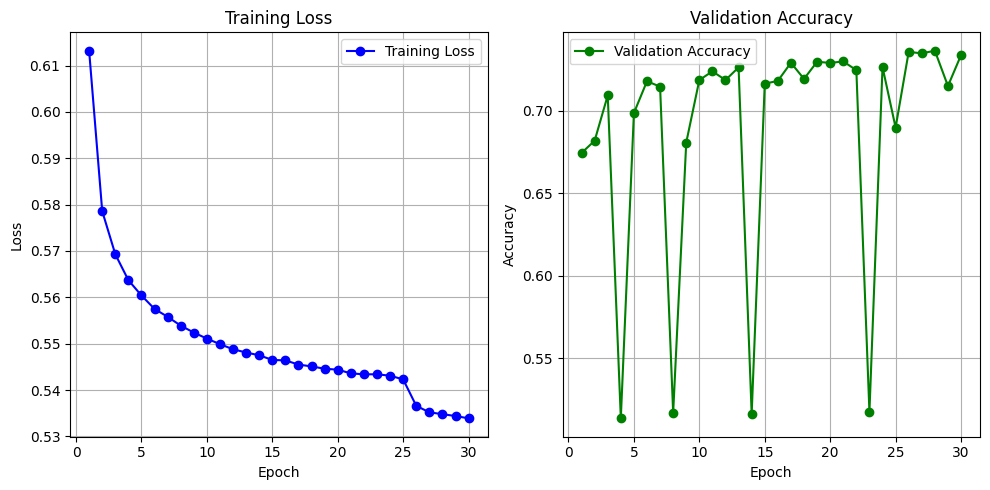

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", color='blue', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='green', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig("training_curve_partial.png")  # Save to file if needed
plt.show()


In [16]:
torch.save(model.state_dict(), "resnet15_detector.pth")
